# B4: Less Than Oracle II

## Problem Statement
You are given integers $n$ and $L$. Implement the oracle $O$ on a quantum circuit $qc$ with $n$ qubits, which multiplies all the probability amplitudes $a_i$ of the computational basis states 
$\lvert 0 \rangle, \lvert 1 \rangle, \dots, \lvert L-1 \rangle$ by $-1$.

## Constraints
- $1 \leq n \leq 10$
- $1 \leq L \leq 2^n$
- The circuit depth must not exceed $50$.
- Global phase is ignored in judgment.
- Integers must be encoded in **little-endian** format.

## Sample Input
For $n = 2$, $L = 3$, the initial state is:

$$
\frac{1}{\sqrt{4}} ( \lvert 00 \rangle + \lvert 10 \rangle + \lvert 01 \rangle + \lvert 11 \rangle ).
$$

The implemented oracle $O$ should apply the transformation:

$$
\frac{1}{\sqrt{4}} ( \lvert 00 \rangle + \lvert 10 \rangle + \lvert 01 \rangle + \lvert 11 \rangle ) \xrightarrow{O} \frac{1}{\sqrt{4}} ( -\lvert 00 \rangle - \lvert 10 \rangle - \lvert 01 \rangle + \lvert 11 \rangle ).
$$


In [63]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZGate

def solve(n: int, L: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    #----------------------------------
    for k in range(n):   #remove this part while submitting
        qc.h(k)
    #-----------------------------------
    # Step 1: Get the binary representation of L (with leading zeros)
    binary_repr = format(L, f'0{n}b')
    
    # Step 2: Reverse the binary representation to get little-endian
    little_endian_binary_repr = binary_repr[::-1]

    # Step 3: Iterate over each qubit (from 0 to n-1)
    for i in range(n):
        # Check the value of the i-th bit in the little-endian binary representation of L
        if little_endian_binary_repr[i] == '0':
            continue  # Skip if the bit is 0

        # Apply X gates to the qubits for the remaining qubits
        for j in range(i + 1, n):
            if little_endian_binary_repr[j] == '0':
                qc.x(j)

        qc.x(i)  # Apply X gate to the current qubit

        # Apply the Z gate or multi-controlled Z gate
        if i == n - 1:
            qc.z(i)  # Apply Z to the last qubit
        else:
            qc.append(ZGate().control(n - i - 1), range(i, n))  # Apply multi-controlled Z

        qc.x(i)  # Reset the X gate on the current qubit

        # Reset the X gates on the remaining qubits
        for j in range(i + 1, n):
            if little_endian_binary_repr[j] == '0':
                qc.x(j)

    return qc


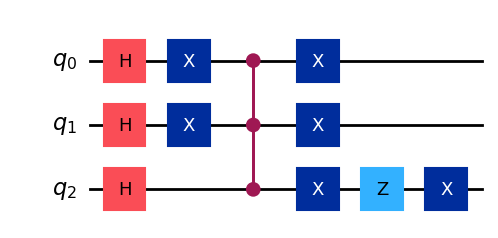

In [64]:
qc = solve(3,5)

qc.draw('mpl')

In [65]:
from qiskit.quantum_info import Statevector

statevector = Statevector(qc)

statevector.draw('latex')

<IPython.core.display.Latex object>

# Solution Approach
To implement the oracle $O$ that negates the amplitudes of computational basis states $|0\rangle, |1\rangle, \dots, |L-1\rangle$, we use the following steps:

### **Step 1: Convert $L$ to Binary (Little-Endian Format)**
- Convert $L$ into an $n$-bit binary representation.
- Reverse the binary string to match **little-endian** ordering (least significant bit first).

### **Step 2: Iterate Over Each Qubit**
For each qubit **i** (from 0 to $n-1$):
1. **Check if the bit in $L$ is `0`**: If the bit is `0`, skip the iteration, as the control condition won't be satisfied. This ensures that only states in the range $[0, L-1]$ are affected.
2. **Apply Temporary `X` Gates**: Flip qubits that are `0` in the binary representation to `1` using `X` gates. This ensures that they can act as **control qubits** for a multi-controlled `Z` operation.
3. **Apply an `X` Gate to the Current Qubit**: This is needed to define the condition for the multi-controlled `Z` operation.
4. **Apply the Multi-Controlled `Z` Gate**:
   - If **`i == n - 1`** (last qubit), apply a single `Z` gate.
   - Otherwise, apply a **multi-controlled `Z`** gate on qubits from `i` to `n-1`.
5. **Undo the Temporary `X` Gates**: Restore the original states of qubits that were flipped in step 2 and 3.

### **Step 3: Resulting Effect**
- The controlled-Z gates apply a **phase flip (-1 factor)** to states $|0\rangle$ to $|L-1\rangle$.
- States $|L\rangle$ to $|2^n - 1\rangle$ remain unchanged.

### **Why We Skip `0` Bits and Work Only on `1` Bits**
- We only process the qubits corresponding to `1` bits in the binary representation of $L$.
- This ensures that we only modify the probability amplitudes within the range `[0, L-1]`, leaving the states outside this range unaffected.

## **Why This Approach Has Lower Depth**
- Instead of iterating through all possible computational states (which would require an exponential number of operations), we efficiently **construct multi-controlled Z gates** based on the binary structure of $L$.
- The **use of temporary `X` gates** allows us to control the Z gate without needing extra ancilla qubits.
- Multi-controlled `Z` gates are efficiently implemented using existing Qiskit primitives, keeping the **circuit depth below 50**.
- The structure avoids unnecessary operations on qubits that do not contribute to the oracle's condition.

## **Time Complexity Analysis**
- **Binary Conversion:** $O(n)$
- **Iteration Over Qubits:** $O(n)$
- **Multi-Controlled `Z` Application:** Efficiently implemented, avoiding exponential growth
- **Overall Complexity:** **$O(n)$**, making it optimal for large values of $n$.

### **Depth Analysis: Comparison with a Naïve Approach**
- A naïve approach would iterate over all states from `0` to `L-1` and apply a **multi-controlled Z gate** to each state.
- This would require **$O(L)$**  (where $L_{max} = 2^n$ ) applications of multi-controlled `Z` gates, each with depth **$O(n)$**, leading to an overall depth of **$O(nL)$**.
- Our approach, by leveraging binary representation and skipping `0` bits, achieves **$O(n)$** depth, significantly improving efficiency.

